In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from PIL import Image
import pickle
from tensorflow.keras.applications import ResNet50
import os
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np

Init Plugin
Init Graph Optimizer
Init Kernel


In [5]:
# try:
#     # TPU detection. No parameters necessary if TPU_NAME environment variable is
#     # set: this is always the case on Kaggle.
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
#     strategy = tf.distribute.get_strategy()

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [2]:
IMAGE_SIZE = 224
#BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
! pip install split-folders
! pip install split-folders tqdm

In [4]:
import splitfolders
splitfolders.ratio("/Users/kazmi/Stuff/potato_disease/PlantVillage/Tomato", output="tomato", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values


Copying files: 16012 files [00:07, 2180.32 files/s]


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        'tomato/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse",
#         save_to_dir="C:\\Code\\potato-disease-classification\\training\\AugmentedImages"
)

Found 12804 images belonging to 10 classes.


In [6]:
train_generator.class_indices
class_names = list(train_generator.class_indices.keys())
class_names


['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
validation_datagen = ImageDataGenerator(
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        'tomato/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse"
)

Found 1597 images belonging to 10 classes.


In [8]:
test_datagen = ImageDataGenerator(
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        'tomato/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse"
)

Found 1610 images belonging to 10 classes.


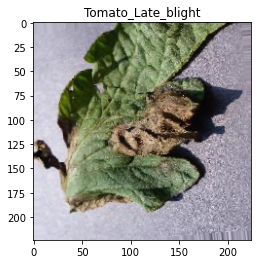

In [9]:
for image_batch, label_batch in test_generator:
    first_image = image_batch[0]/255
    first_label = int(label_batch[0])
    
    plt.imshow(first_image)
    plt.title(class_names[first_label])
    
    
    break

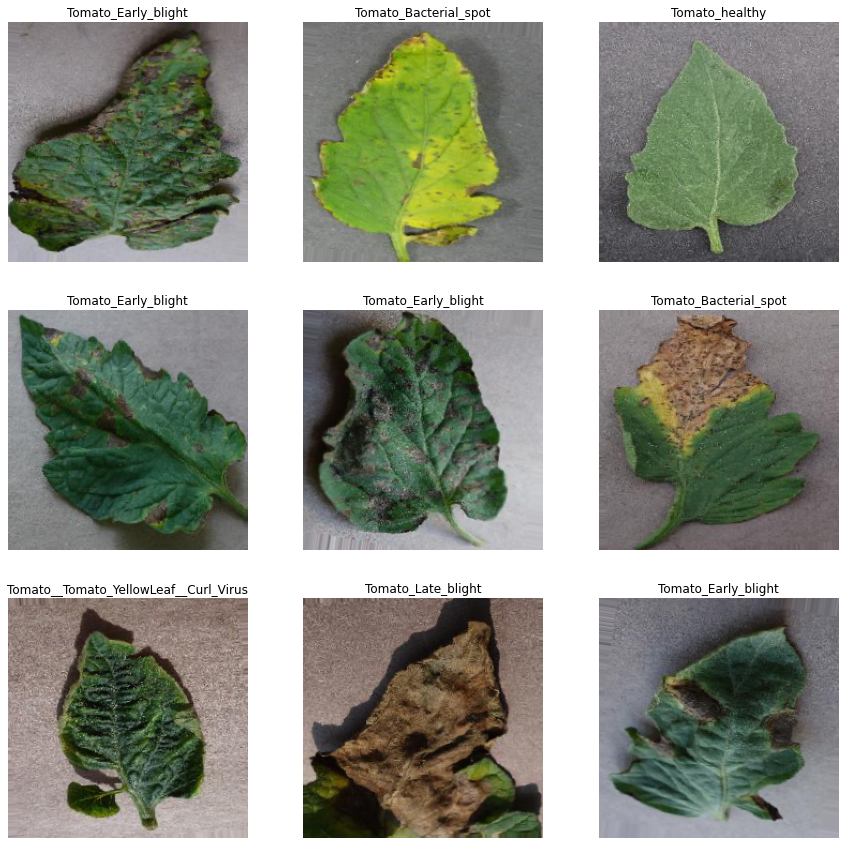

In [10]:
plt.figure(figsize=(15, 15))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        actual_class = class_names[int(labels[i])] 
        plt.title(f"{actual_class}")
        plt.imshow(images[i]/255)
                
        plt.axis("off")
    break

#Building the Model


In [11]:
image_shape = (224,224)
input_shape = image_shape + (3,)

# with strategy.scope():


base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                include_top=False, 
                                                weights='imagenet')


base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape) 

x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

x = base_model(x,training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)

model2 = model.layers[3]
model2.trainable = True
fine_tune_at = 130
for layer in model2.layers[:fine_tune_at]:
    layer.trainable = False




model.summary()
checkpoint_filepath = '/content/checkpoint'
    
    #to stop if validation stops increasing, to increase LR on platue, to save the best model
callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.75, patience=2, min_lr=0.0000005),
             tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                                       save_weights_only=True,
                                                       monitor='val_loss',
                                                       mode='min',
                                                       save_best_only=True),
             tf.keras.callbacks.TensorBoard(log_dir="./logs"),

     ]

Metal device set to: Apple M1


2021-12-07 17:28:38.270912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-07 17:28:38.271421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


9412608/9406464 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
________________________________________________________________

2021-12-07 17:28:43.958592: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-12-07 17:28:43.958612: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-12-07 17:28:43.959018: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [12]:
loss_function= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics= ['accuracy']


model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=47,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=EPOCHS,
)


2021-12-07 17:28:48.868143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-07 17:28:48.869451: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2021-12-07 17:28:49.918323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 1.4107 - accuracy: 0.5392

2021-12-07 17:29:12.889967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 26s 418ms/step - loss: 1.4107 - accuracy: 0.5392 - val_loss: 0.7867 - val_accuracy: 0.7188
Epoch 2/50
47/47 [==============================] - 19s 407ms/step - loss: 0.6869 - accuracy: 0.7693 - val_loss: 0.6786 - val_accuracy: 0.7396
Epoch 3/50
47/47 [==============================] - 19s 409ms/step - loss: 0.5503 - accuracy: 0.8125 - val_loss: 0.4717 - val_accuracy: 0.8333
Epoch 4/50
47/47 [==============================] - 19s 402ms/step - loss: 0.4752 - accuracy: 0.8404 - val_loss: 0.4040 - val_accuracy: 0.8594
Epoch 5/50
 6/47 [==>...........................] - ETA: 14s - loss: 0.4634 - accuracy: 0.8438

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


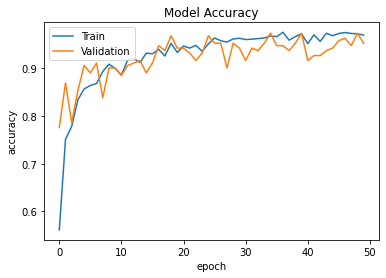

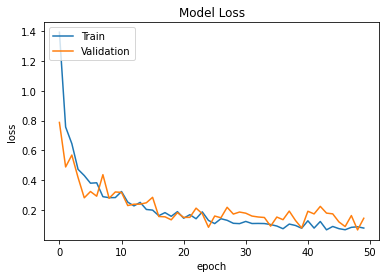

KeyError: ignored

In [43]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for learning rate
plt.plot(history.history['lr'])
plt.title('Model Learning Rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend(['Learning Rate'], loc='upper left')
plt.show()

In [49]:
! mkdir models
! mkdir Models


mkdir: cannot create directory ‘models’: File exists


In [50]:
model_version =  1
model.save_weights(f"/content/Models/{model_version}.h5")

In [51]:
model_version = 1
model.save(f"/content/models/{model_version}")

INFO:tensorflow:Assets written to: /content/models/1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [47]:
model.save("tomatos_1.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [48]:
! zip -r models.zip models

  adding: models/ (stored 0%)
  adding: models/1/ (stored 0%)
  adding: models/1/keras_metadata.pb (deflated 96%)
  adding: models/1/variables/ (stored 0%)
  adding: models/1/variables/variables.index (deflated 76%)
  adding: models/1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: models/1/saved_model.pb (deflated 92%)
  adding: models/1/assets/ (stored 0%)
  adding: models/1.h5 (deflated 9%)
